<a href="https://colab.research.google.com/github/ngochif/fngochi_64061/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time Series

In [3]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-01 09:31:22--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.84.62, 54.231.197.224, 54.231.139.248, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.84.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  --.-KB/s    in 0.09s   

2024-04-01 09:31:23 (140 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Inspecting the data

In [4]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Parsing the data

In [5]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

Plotting the temperature timeseries

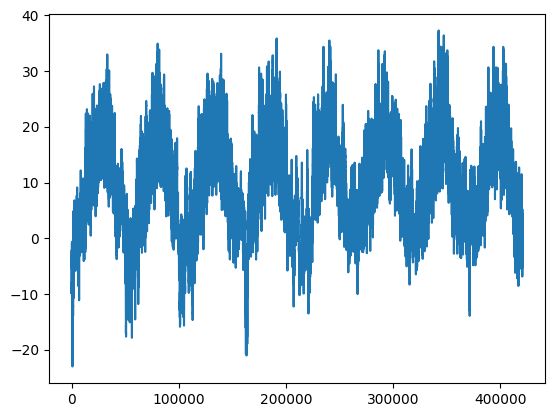

In [6]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


PREPARING THE DATA

Normalizing Data

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Instantiating dataset

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Adjusting the number of units in stacked RNN with dropout

**Original discussed in class**

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout_original.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout_original.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 310s 372ms/step - loss: 27.3849 - mae: 3.8268 - val_loss: 9.7472 - val_mae: 2.4227
Epoch 2/50
819/819 [==============================] - 289s 353ms/step - loss: 14.0189 - mae: 2.8949 - val_loss: 8.9462 - val_mae: 2.3229
Epoch 3/50
819/819 [==============================] - 283s 345ms/step - loss: 13.1383 - mae: 2.8120 - val_loss: 9.4118 - val_mae: 2.3877
Epoch 4/50
819/819 [==============================] - 276s 337ms/step - loss: 12.5235 - mae: 2.7451 - val_loss: 9.4429 - val_mae: 2.3945
Epoch 5/50
819/819 [==============================] - 314s 383ms/step - loss: 12.1121 - mae: 2.6999 - val_loss: 8.9298 - val_mae: 2.3218
Epoch 6/50
819/819 [==============================] - 311s 378ms/step - loss: 11.6557 - mae: 2.6522 - val_loss: 8.7014 - val_mae: 2.2851
Epoch 7/50
819/819 [==============================] - 308s 376ms/step - loss: 11.2648 - mae: 2.6077 - val_loss: 8.9762 - val_mae: 2.3288
Epoch 8/50
819/819 [=====================

Plotting Original Stacked Model

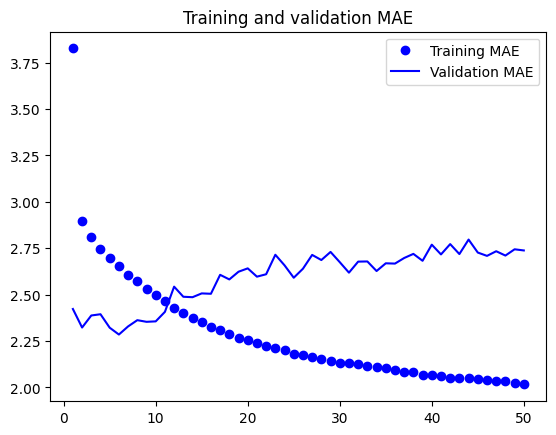

In [12]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE Original")
plt.plot(epochs, val_loss, "b", label="Validation MAE Original")
plt.title("Training and validation MAE Original")
plt.legend()
plt.show()

Adding more units to the recurrent layer

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(18, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(18, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 292s 348ms/step - loss: 41.4634 - mae: 4.7495 - val_loss: 11.9007 - val_mae: 2.6036
Epoch 2/50
819/819 [==============================] - 279s 340ms/step - loss: 17.7859 - mae: 3.2314 - val_loss: 10.0197 - val_mae: 2.4587
Epoch 3/50
819/819 [==============================] - 279s 341ms/step - loss: 16.4263 - mae: 3.1112 - val_loss: 9.2867 - val_mae: 2.3776
Epoch 4/50
819/819 [==============================] - 279s 340ms/step - loss: 15.6781 - mae: 3.0422 - val_loss: 9.0039 - val_mae: 2.3390
Epoch 5/50
819/819 [==============================] - 278s 339ms/step - loss: 15.0931 - mae: 2.9902 - val_loss: 9.3159 - val_mae: 2.3893
Epoch 6/50
819/819 [==============================] - 278s 339ms/step - loss: 14.5063 - mae: 2.9349 - val_loss: 8.7614 - val_mae: 2.3000
Epoch 7/50
819/819 [==============================] - 278s 339ms/step - loss: 14.0851 - mae: 2.8959 - val_loss: 8.7380 - val_mae: 2.3016
Epoch 8/50
819/819 [===================

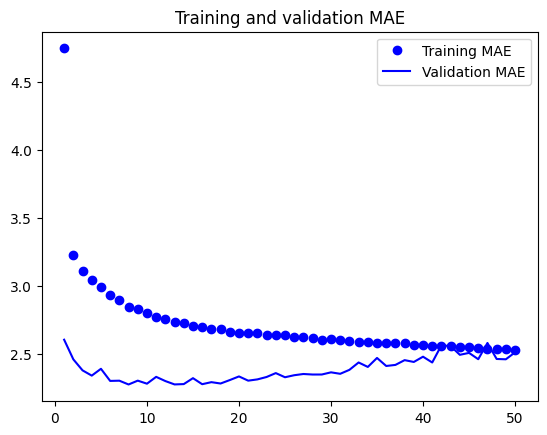

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE-Fewer Units")
plt.plot(epochs, val_loss, "b", label="Validation MAE-Fewer Units")
plt.title("Training and validation MAE-Fewer Units")
plt.legend()
plt.show()

Having more units in the recurrent layers

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(50, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(50, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout_more_units.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout_more_units.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 473s 571ms/step - loss: 18.9867 - mae: 3.2584 - val_loss: 9.5985 - val_mae: 2.4076
Epoch 2/50
819/819 [==============================] - 461s 563ms/step - loss: 12.2800 - mae: 2.7281 - val_loss: 9.2142 - val_mae: 2.3419
Epoch 3/50
819/819 [==============================] - 460s 562ms/step - loss: 11.5844 - mae: 2.6510 - val_loss: 8.6880 - val_mae: 2.2992
Epoch 4/50
819/819 [==============================] - 463s 564ms/step - loss: 10.8929 - mae: 2.5688 - val_loss: 8.7171 - val_mae: 2.2902
Epoch 5/50
819/819 [==============================] - 467s 569ms/step - loss: 10.3348 - mae: 2.5041 - val_loss: 9.2715 - val_mae: 2.3629
Epoch 6/50
819/819 [==============================] - 462s 564ms/step - loss: 9.8258 - mae: 2.4395 - val_loss: 9.3657 - val_mae: 2.3999
Epoch 7/50
819/819 [==============================] - 464s 566ms/step - loss: 9.3191 - mae: 2.3747 - val_loss: 9.7394 - val_mae: 2.4372
Epoch 8/50
819/819 [=======================

OSError: No file or directory found at jena_stacked_gru_dropout.keras

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.models.load_model("jena_stacked_gru_dropout_more_units.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

OSError: No file or directory found at jena_stacked_gru_dropout_more_units.keras

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE-More Units")
plt.plot(epochs, val_loss, "b", label="Validation MAE-More Units")
plt.title("Training and validation MAE-More Units")
plt.legend()
plt.show()

Using LSTM instead of GRU

Combining 1D ConvNet and RNN